In [21]:
import sys
sys.path.append("V:/biomoni/")                      #without this line windows could not acces the package 
from biomoni import Experiment
from BacillusScripts.BacillusVariableFeedrate import Bacillus_vf
from BacillusScripts.visualizationBacillus import visualizeBacillusFermentation
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from lmfit import Parameters
from IPython.display import display

path = r"V:/biomoni/BacillusData/Stamm186"

experiment_dict_for_estimation = {exp : Experiment(path, exp,endpoint = "Sim_end") for exp in ["F7"]}  #all experiments in a dictionary   
experiment_dict_for_graphs = {exp : Experiment(path, exp, endpoint = "F_end") for exp in ["F7"]} 




#Exp = experiment_dict 
b= Bacillus_vf()
b.estimate(experiment_dict_for_estimation)  
  
  
b.report()
print(b.p)

for key in b.stat_single.keys():
    df = pd.DataFrame(b.stat_single[key].values(), index = b.stat_single[key].keys())
    df_t=df.transpose()
    df_t["ID"]= key
    df_t["type"] = "single"
    print(df_t)
    


df_stat_all = pd.DataFrame(b.stat_all.values(), index = b.stat_all.keys())
df_stat_all_t= df_stat_all.transpose()
df_stat_all_t["ID"]= path
print(df_stat_all_t)



sim_dict_all= {}
for exp in experiment_dict_for_estimation.values():
    sim_end_h=exp.dataset["on"].index[-1]
    t_grid = np.linspace(0,sim_end_h,1001)
    sim_dict=  b.simulate(experiment = exp, t_grid = t_grid)
    sim_dict_all[exp.exp_id] = sim_dict



sim_list=list(sim_dict_all.values())
experiment_list=list(experiment_dict_for_graphs.values())
# put experimental data in dictionary in form of {"F1":{"off": ---DataFrame---,"on": ---DataFrame---,"CO2": ---DataFrame--- |etc.}}
ex ={}

for obj in experiment_list:
    ex[obj.exp_id]= obj.dataset 
        
# put simulated data in dictionary in form of {"F1":{"simulated": ---DataFrame--- |etc}}

sim_list=list(sim_dict_all.values())
sim ={}
for key in experiment_dict_for_graphs.keys():
    sim[key] = {}
 
sim_complete = {list(sim)[i]: {"simulated":sim_list[i]}for i in range(len(sim_list))}

#calculate Carbon recovery 
CRR_all ={}

for key in experiment_dict_for_graphs.keys():
    CRR_all[key]= {}

for key, dat in sim_dict_all.items():
    V_func= interp1d(x=sim_dict_all[key]["V"].index, y=sim_dict_all[key]["V"], fill_value = (sim_dict_all[key]["V"].iloc[0], sim_dict_all[key]["V"].iloc[-1]) , bounds_error= False)
    exp =Experiment(path, key, endpoint="F_end")
    c = b.create_controls(exp)
    y0 = b.create_y0(exp)
    #datasaet = exp.dataset
    
    CRR1, CRR2 = b.calc_CRR(experiment=exp,c=c,V=V_func,y0=y0)
    
    CRR_all[key]= {"CR1": CRR1,"CR2": CRR2}


   
# bring both dictionaries together in form of {"F1":{"simulated" ---DataFrame---,"off": ---DataFrame---,"on": ---DataFrame---,"CO2": ---DataFrame--- |etc.}}

dict_for_graphs = {}
dict_for_graphs = sim_complete
dfg = dict_for_graphs  
for id in dict_for_graphs.keys():
    dict_for_graphs[id].update(ex[id])
    dict_for_graphs[id].update(CRR_all[id])         


#visualizeBacillusFermentation(dfg)
print(CRR1,CRR2)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 27
    # variables        = 3
    chi-square         = 0.42664609
    reduced chi-square = 0.01777692
    Akaike info crit   = -105.986207
    Bayesian info crit = -102.098697
[[Variables]]
    Km:      10 (fixed)
    Yxs:     0.18193900 +/- 0.01019481 (5.60%) (init = 0.1)
    Ypx:     87.0725033 +/- 4.07968877 (4.69%) (init = 100)
    mu_max:  0.40049368 +/- 0.00257412 (0.64%) (init = 0.2)
[[Correlations]] (unreported correlations are < 0.100)
    C(Ypx, mu_max) = -0.584
    C(Yxs, Ypx)    = -0.423
Parameters([('Km', <Parameter 'Km', value=10 (fixed), bounds=[9:11]>), ('Yxs', <Parameter 'Yxs', value=0.18193900224075416 +/- 0.0102, bounds=[0.0001:0.5]>), ('Ypx', <Parameter 'Ypx', value=87.07250329275104 +/- 4.08, bounds=[10:250]>), ('mu_max', <Parameter 'mu_max', value=0.40049367552676496 +/- 0.00257, bounds=[0.01:0.5]>)])
                    RMSE      BIAS     STDDEV  ID    type
Gl

plotting normal distributions with mean= estimated parameters and their estiamted standard deviations

#1 -> strain 185
#2 -> strain 186

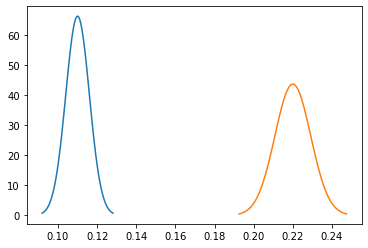

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

#substrate yield

mu = 0.11
sigma = 6.03*10**-3

mu2= 0.22
sigma2 = 9.15*10**-3

x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
x2 = np.linspace(mu2 - 3 * sigma2, mu2 + 3 * sigma2, 100)


plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.plot(x2,stats.norm.pdf(x2, mu2, sigma2))
plt.show()

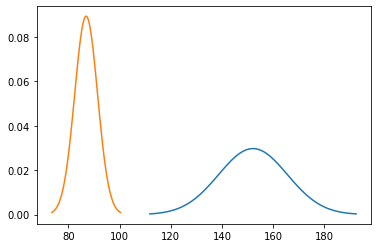

In [26]:
#product yield 


mu = 152.12
sigma = 13.43

mu2= 86.95
sigma2 = 4.47

x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
x2 = np.linspace(mu2 - 3 * sigma2, mu2 + 3 * sigma2, 100)


plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.plot(x2,stats.norm.pdf(x2, mu2, sigma2))
plt.show()

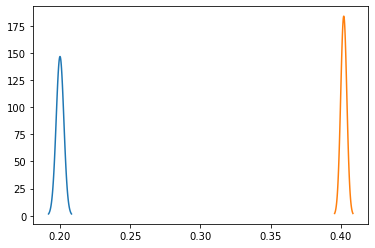

In [27]:
#max growth rate


mu = 0.2
sigma = 2.72*10**-3

mu2= 0.402
sigma2 = 2.17*10**-3

x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
x2 = np.linspace(mu2 - 3 * sigma2, mu2 + 3 * sigma2, 100)


plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.plot(x2,stats.norm.pdf(x2, mu2, sigma2))
plt.show()